In [ ]:
!pip install sklearn_crfsuite
! pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import sklearn_crfsuite as crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn_crfsuite.utils import flatten
from functools import wraps

In [ ]:

import joblib

In [ ]:
import  nltk
from nltk import word_tokenize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('treebank')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [ ]:
def load_dataset(X_file,y_file,pos_file):
  '''laod data set and crete list of tuples (word,tag) '''
  X=[]
  with open(X_file) as f:
    # X_train=f.read().splitlines()
    for line in f:
      X.append(word_tokenize(line))

  y=[]
  with open(y_file) as f:
    for line in f:
      y.append(word_tokenize(line))
  tag=[]
  with open(pos_file) as f:
    for line in f:
      tag.append(eval(line))

  dataset= [[(x,t,y) for x,t,y in zip(sublist1,sublist_t, sublist2)] \
                  for sublist1, sublist_t,sublist2 in zip(X, tag,y)]
  return dataset

In [ ]:
train_set=load_dataset("NERtr_in.txt","NERtr_out.txt",'pos_tag_train_ner.txt')
val_set=load_dataset("NERvalid_in.txt","NERvalid_out.txt",'pos_tag_val_ner.txt')
test_set=load_dataset("NERtest_in.txt","NERtest_out.txt",'pos_tag_test_ner.txt')


FileNotFoundError: ignored

In [ ]:
# nltk.download('conll2002')

In [ ]:
! wget https://raw.githubusercontent.com/nlptown/nlp-notebooks/master/data/embeddings/clusters_nl.tsv

--2023-05-13 15:15:43--  https://raw.githubusercontent.com/nlptown/nlp-notebooks/master/data/embeddings/clusters_nl.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 459810 (449K) [text/plain]
Saving to: ‘clusters_nl.tsv’

clusters_nl.tsv     100%[===================>] 449.03K  --.-KB/s    in 0.007s  

2023-05-13 15:15:44 (67.2 MB/s) - ‘clusters_nl.tsv’ saved [459810/459810]



In [ ]:
def read_clusters(cluster_file):
    word2cluster = {}
    with open(cluster_file) as i:
        for line in i:
            word, cluster = line.strip().split('\t')
            word2cluster[word] = cluster
    return word2cluster
  

In [ ]:
word2cluster=read_clusters("clusters_nl.tsv")

In [ ]:

def ner_word2features(sent, i, word2cluster):
    word = sent[i][0]
    postag = sent[i][1]
    features = [
        'bias',
        'word.lower=' + word.lower(),
        'word[-3:]=' + word[-3:],
        'word[-2:]=' + word[-2:],
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'word.cluster=%s' % word2cluster[word.lower()] if word.lower() in word2cluster else "0",
        'postag=' + postag
    ]
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.extend([
            '-1:word.lower=' + word1.lower(),
            '-1:word.istitle=%s' % word1.istitle(),
            '-1:word.isupper=%s' % word1.isupper(),
            '-1:postag=' + postag1
        ])
    else:
        features.append('BOS')

    if i > 1: 
        word2 = sent[i-2][0]
        postag2 = sent[i-2][1]
        features.extend([
            '-2:word.lower=' + word2.lower(),
            '-2:word.istitle=%s' % word2.istitle(),
            '-2:word.isupper=%s' % word2.isupper(),
            '-2:postag=' + postag2
        ])        

        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.extend([
            '+1:word.lower=' + word1.lower(),
            '+1:word.istitle=%s' % word1.istitle(),
            '+1:word.isupper=%s' % word1.isupper(),
            '+1:postag=' + postag1
        ])
    else:
        features.append('EOS')

    if i < len(sent)-2:
        word2 = sent[i+2][0]
        postag2 = sent[i+2][1]
        features.extend([
            '+2:word.lower=' + word2.lower(),
            '+2:word.istitle=%s' % word2.istitle(),
            '+2:word.isupper=%s' % word2.isupper(),
            '+2:postag=' + postag2
        ])

        
    return features

In [ ]:
def ner_sent2features(sent, word2cluster):
    return [ner_word2features(sent, i, word2cluster) for i in range(len(sent))]

def ner_sent2labels(sent):
    return [label for token, postag, label in sent]

def ner_sent2tokens(sent):
    return [token for token, postag, label in sent]
    

In [ ]:
# ner_sent2features(train_set[0], word2cluster)[1]

NameError: ignored

In [ ]:


X_train = [ner_sent2features(s, word2cluster) for s in train_set]
y_train = [ner_sent2labels(s) for s in train_set]

X_val = [ner_sent2features(s, word2cluster) for s in val_set]
y_val = [ner_sent2labels(s) for s in val_set]

X_test = [ner_sent2features(s, word2cluster) for s in test_set]
y_test = [ner_sent2labels(s) for s in test_set]

In [ ]:
crf = crfsuite.CRF(
    verbose='true',
    algorithm='lbfgs',
    max_iterations=200,
    c1=0.1,
    c2=0.1,
    all_possible_transitions=True
)
try:
    crf.fit(X_train, y_train, X_dev=X_val, y_dev=y_val)
except AttributeError:
    pass

loading training data to CRFsuite: 100%|██████████| 6973/6973 [00:06<00:00, 1108.50it/s]


loading dev data to CRFsuite: 100%|██████████| 1739/1739 [00:02<00:00, 740.55it/s]



Holdout group: 2

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 150836
Seconds required: 1.609

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 200
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=1.15  loss=152952.72 active=150054 precision=0.093  recall=0.111  F1=0.101  Acc(item/seq)=0.833 0.160  feature_norm=1.00
Iter 2   time=0.70  loss=149626.65 active=140681 precision=0.093  recall=0.111  F1=0.101  Acc(item/seq)=0.833 0.160  feature_norm=1.05
Iter 3   time=0.69  loss=132128.24 active=138719 precision=0.093  recall=0.111  F1=0.101  Acc(item/seq)=0.833 0.160  feature_norm=1.37
Iter 4   time=0.69  loss=105522.95 active=147244 precision=0.153  recall=0.118  F1=0.114  Acc(item/seq)=0.833 0.160  feature_norm=2.29
Iter 5   time=0.70  loss=95035.97 active

In [ ]:


import joblib
import os

OUTPUT_PATH = "./"
OUTPUT_FILE = "crf_model_ner"

if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

joblib.dump(crf, os.path.join(OUTPUT_PATH, OUTPUT_FILE))



['./crf_model_ner']

In [ ]:
# X_val

NameError: ignored

In [ ]:
y_pred=crf.predict(X_val)


In [ ]:
metrics.flat_accuracy_score(y_val, y_pred)


0.9536196892402352

In [ ]:
metrics.flat_recall_score(y_val, y_pred,average='macro')


0.806515486506417

In [ ]:
metrics.flat_precision_score(y_val, y_pred,average='macro')


0.8620405616552316

In [ ]:
with open('ner_out_file.txt', 'w') as f:
  for sentence in y_pred:
    f.write(f"{sentence}\n")

In [ ]:
train_tagged_words = [ tup for sent in train_set for tup in sent ]

tags = {ner for word,tag,ner in train_tagged_words}


In [ ]:
len(y_true_flat),len(y_pred_flat)

(51358, 51358)

In [ ]:
y_true_flat = flatten(y_val)
y_pred_flat = flatten(y_pred)
cm = confusion_matrix(y_true_flat, y_pred_flat,labels=list(tags))
disp=ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=tags)

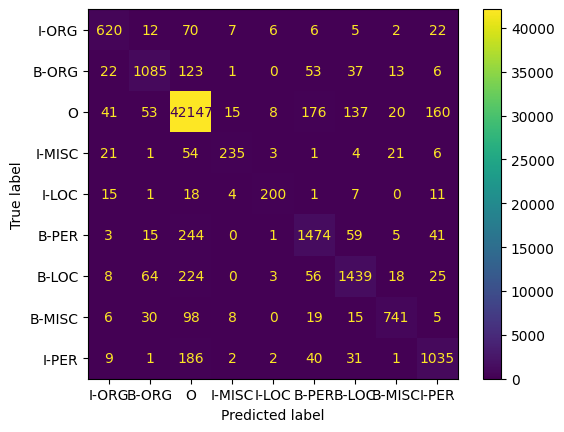

In [ ]:
disp.plot()

# NER labling

In [ ]:
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from gensim.models import Word2Vec

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def pos_word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word': word,
        'len(word)': len(word),
        'word[:4]': word[:4],
        'word[:3]': word[:3],
        'word[:2]': word[:2],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-4:]': word[-4:],
        'word.lower()': word.lower(),
        'word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word.lower()),
        'word.ispunctuation': (word in string.punctuation),
        'word.isdigit()': word.isdigit(),
    }    
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1,
            '-1:len(word)': len(word1),
            '-1:word.lower()': word1.lower(),
            '-1:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word1.lower()),
            '-1:word[:3]': word1[:3],
            '-1:word[:2]': word1[:2],
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.ispunctuation': (word1 in string.punctuation),
        })
    else:
        features['BOS'] = True

    if i > 1:
        word2 = sent[i-2][0]
        features.update({
            '-2:word': word2,
            '-2:len(word)': len(word2),
            '-2:word.lower()': word2.lower(),
            '-2:word[:3]': word2[:3],
            '-2:word[:2]': word2[:2],
            '-2:word[-3:]': word2[-3:],
            '-2:word[-2:]': word2[-2:],
            '-2:word.isdigit()': word2.isdigit(),
            '-2:word.ispunctuation': (word2 in string.punctuation),
        })

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word': word1,
            '+1:len(word)': len(word1),
            '+1:word.lower()': word1.lower(),
            '+1:word[:3]': word1[:3],
            '+1:word[:2]': word1[:2],
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.ispunctuation': (word1 in string.punctuation),
        })

    else:
        features['EOS'] = True    
    if i < len(sent) - 2:
        word2 = sent[i+2][0]
        features.update({
            '+2:word': word2,
            '+2:len(word)': len(word2),
            '+2:word.lower()': word2.lower(),
            '+2:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word2.lower()),
            '+2:word[:3]': word2[:3],
            '+2:word[:2]': word2[:2],
            '+2:word[-3:]': word2[-3:],
            '+2:word[-2:]': word2[-2:],
            '+2:word.isdigit()': word2.isdigit(),
            '+2:word.ispunctuation': (word2 in string.punctuation),
        })

    return features


def pos_sent2features(sent):
    return [pos_word2features(sent, i) for i in range(len(sent))]

def pos_sent2labels(sent):
    return [word[1] for word in sent]

def pos_sent2tokens(sent):
    return [word[0] for word in sent]

In [ ]:
text = "John Smith works at Google in New York"


In [ ]:
pos_crf=joblib.load('pos_crf_model')
ner_crf=joblib.load('crf_model_ner')


In [ ]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    
    
    # POS tags list of (word, tag)
    
    pos_tags = [(x,y) for x,y in zip(tokens,pos_crf.predict(pos_sent2features([text]))[0])]

    pos_words = [word for word, tag in pos_tags if tag.startswith('N') or tag.startswith('V') or tag.startswith('J')]

    ner_preds=ner_crf.predict([ner_sent2features(pos_tags, word2cluster)])[0]
    ner_tags=[(x,y) for x,y in zip(tokens,ner_preds)]

    named_entities = [ word for word, label in  ner_tags\
                      if label.startswith('PER') or label.startswith('ORG')\
                      or label.startswith('LOC')]


    important_words=named_entities + pos_words
    # Filter out stop words from outputs
    stop_words = set(stopwords.words('english'))
    important_words = [word for word in important_words if word not in stop_words and word.isalpha()]
    
    return important_words

In [ ]:
def sentence_embedding(text):
    # Preprocess the text and extract the relevant words
    imp_words = preprocess_text(text)
    
    # Train a Word2Vec model on the relevant words
    model = Word2Vec([imp_words], min_count=1)
    
    # Calculate the word embeddings for the relevant words
    word_embeddings = [model.wv[entity] for entity in imp_words]
    #  [model.wv[word] for wonamed_entities = [ent for ent in doc.ents if ent.label_.startswith('PER') or ent.label_.startswith('ORG') or ent.label_.startswith('LOC')]rd in pos_words]
    
    # Calculate the sentence embedding as the average of the word embeddings
    sentence_embedding = sum(word_embeddings) / float(len(word_embeddings))
    
    return sentence_embedding

In [ ]:
text = "Two goals from defensive errors in the last six minutes\
 allowed Japan to come from behind and \
collect all three points from their opening meeting against Syria"
embedding = sentence_embedding(text)
print(embedding)


[-4.57795756e-03  1.95108471e-03  5.14661660e-03  7.37560540e-03
 -9.18015605e-04 -6.64224196e-03  3.78224300e-03  7.51013542e-03
 -3.92773934e-03 -4.96844715e-03  3.48514086e-03 -4.95120976e-03
 -5.06831286e-03  6.82929531e-03 -7.53810396e-04  2.70482595e-03
  4.83841356e-03  4.26130788e-03 -6.03718497e-03 -5.00531215e-03
  4.83007124e-03  2.75614904e-04  7.57321250e-03 -4.54764906e-03
  6.55776542e-03 -2.45474512e-04 -2.93961633e-03  5.08338027e-03
 -4.63060616e-03  1.38764037e-03  1.22663379e-03 -2.64624273e-03
  4.46939049e-03 -6.50740229e-03  7.58526847e-04  4.24442871e-04
  7.48425676e-03  8.50998331e-05  4.79182974e-03  2.25984165e-03
 -8.52741301e-04 -9.91105568e-04 -8.95772502e-03 -2.37378897e-03
 -1.56747038e-03  3.79906758e-03 -8.61332985e-04  4.03454015e-03
  3.24651063e-03  5.51159214e-03 -1.70173123e-04 -2.50719418e-03
 -2.17130361e-03  2.14686641e-03  3.77982389e-03  1.95979769e-03
  6.76414184e-03 -1.25226798e-04 -2.13005487e-03  8.55445582e-03
 -5.05599380e-03  1.76423

In [ ]:


# def _flattens_y(func):
#     @wraps(func)
#     def wrapper(y_true, y_pred, *args, **kwargs):
#         y_true_flat = flatten(y_true)
#         y_pred_flat = flatten(y_pred)
#         return func(y_true_flat, y_pred_flat, *args, **kwargs)
#     return wrapper

In [ ]:
@_flattens_y
# def plot_conf_matrix(y_true, y_pred,tags):
#   y_true_flat = flatten(y_true)
#   y_pred_flat = flatten(y_pred)
#   cm = confusion_matrix(y_true_flat, y_pred_flat,labels=tags)
#   disp=ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=tags)
#   disp.plot()#include_values=False, cmap="viridis", ax=None, xticks_rotation="vertical")
#   plt.show()

In [ ]:
# plot_conf_matrix(y_val, y_pred,list(tags))
